# IBM Data Science Capstone Project

## Segmenting and Clustering Neighborhoods in Milano

__Importing all necessary libraries__

In [169]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library


print('Libraries imported.')

Libraries imported.


### Milano, Italy

The scope of the project is to find the "most livable" parts of Milano, by merging information regards variety of services and venues (such as restaurants, bars, gyms) and information about green areas and parks.

Data abut venues have been scraped from Foursquare.com.
Data about parks, green areas and dog areas have been found on the website of the'Comune di Milano' (https://dati.comune.milano.it/) and analyzied in separate notebooks.

__For the scope of the IBM Final assignment it is possible to look only at this notebook__, but for more information is possible to see also the other notebooks in the repository.

Below it is shown how the city of Milano is organized:
it is divided in 9 "Municipi" (Boroughs) that are composed by several "Nuclei di identità locale" (NIL or neighborhoods).

In this work the abbreviation NIL will be used. The NILs are 8 in total.

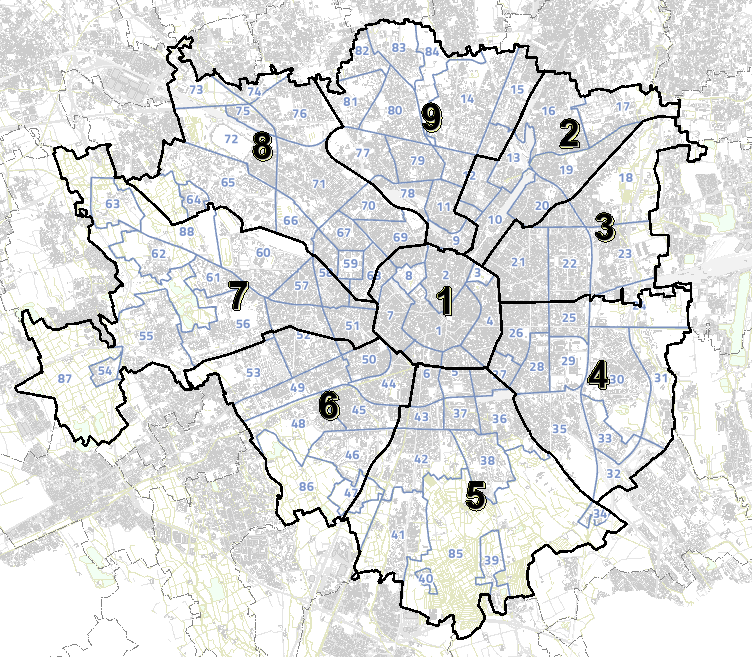

#### Importing dataset 

-NIL_data.csv is a combination of 2 dataets found on https://dati.comune.milano.it/
    
_(for the manipulation see notebook: 1 DF Manipulation NIL&MUN.ipynb)_

In [170]:
df_NIL=pd.read_csv('NIL_data') #data with geographical coordinates of the NILs of Milano

In [171]:
print(df_NIL.shape)
df_NIL.head()

(88, 6)


,ID_NIL,NIL,NIL_Long,NIL_Lat,NIL_Area_mq,MUN
0,1,DUOMO,9.186948,45.463707,2.341704e+06,1
1,2,BRERA,9.188157,45.474252,1.637395e+06,1
2,3,GIARDINI P.TA VENEZIA,9.200231,45.474564,2.496468e+05,1
3,4,GUASTALLA,9.201891,45.463219,1.548021e+06,1
4,5,PORTA VIGENTINA - PORTA LODOVICA,9.192446,45.450950,1.135239e+06,1


In [172]:
#9 Municipi (Boroughs)
#88 NIL (Neighborhoods)

#### Getting information from Foursquare

In [173]:
CLIENT_ID = 'EGJQMFM05ROCXUZRYGQYDJNXI1PK1ZPOZSZDQYHCG1ROL3OX' # your Foursquare ID
CLIENT_SECRET = 'EOYP5JKRWSHAGCJVQ1QYFL2RC2MO3H3QGBQ2RRI5HMTE0J14' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EGJQMFM05ROCXUZRYGQYDJNXI1PK1ZPOZSZDQYHCG1ROL3OX
CLIENT_SECRET:EOYP5JKRWSHAGCJVQ1QYFL2RC2MO3H3QGBQ2RRI5HMTE0J14


In [174]:
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
        print(neighborhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood,  
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                             'NIL',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category'
                            ]
    
    return(nearby_venues)

In [175]:
milano_venues = getNearbyVenues(
                                neighborhoods=df_NIL['NIL'],
                                latitudes=df_NIL['NIL_Lat'],
                                longitudes=df_NIL['NIL_Long']
                                )

DUOMO
BRERA
GIARDINI P.TA VENEZIA
GUASTALLA
PORTA VIGENTINA - PORTA LODOVICA
PORTA TICINESE - CONCA DEL NAVIGLIO
MAGENTA - S. VITTORE
PARCO SEMPIONE
PORTA GARIBALDI - PORTA NUOVA
STAZIONE CENTRALE - PONTE SEVESO
ISOLA
MACIACHINI - MAGGIOLINA
GRECO - SEGNANO
NIGUARDA - CA' GRANDA - PRATO CENTENARO - Q.RE FULVIO TESTI
BICOCCA
GORLA - PRECOTTO
ADRIANO
CIMIANO - ROTTOLE - Q.RE FELTRE
PADOVA - TURRO - CRESCENZAGO
LORETO - CASORETTO - NOLO
BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE
CITTA' STUDI
LAMBRATE - ORTICA
PARCO FORLANINI - CAVRIANO
CORSICA
XXII MARZO
PTA ROMANA
UMBRIA - MOLISE - CALVAIRATE
ORTOMERCATO
TALIEDO - MORSENCHIO - Q.RE FORLANINI
MONLUE' - PONTE LAMBRO
TRIULZO SUPERIORE
ROGOREDO - SANTA GIULIA
CHIARAVALLE
LODI - CORVETTO
SCALO ROMANA
MORIVIONE
VIGENTINO - Q.RE FATIMA
QUINTOSOLE
RONCHETTO DELLE RANE
GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE
STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA FALLATA
TIBALDI
PORTA TICINESE - CONCHETTA
MONCUCCO - SAN CRISTOFORO
BARONA
CANTALUPA

In [176]:
print(milano_venues.shape)
milano_venues.head()

(2212, 5)


,NIL,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DUOMO,Piz,45.462163,9.185767,Pizza Place
1,DUOMO,Starbucks Reserve Roastery,45.464920,9.186153,Coffee Shop
2,DUOMO,Piazza del Duomo,45.464190,9.189527,Plaza
3,DUOMO,Ciacco. Gelato senz'altro,45.463704,9.186796,Ice Cream Shop
4,DUOMO,Venchi,45.465214,9.187340,Ice Cream Shop


In [177]:
print('Found venues for {} NIL.'.format(len(milano_venues['NIL'].unique())))
print('There are {} uniques categories.'.format(len(milano_venues['Venue Category'].unique())))

Found venues for 86 NIL.
There are 260 uniques categories.


#### Let's explore the imported data

After trials and errors it has been decided to not to use all the information

In [178]:
milano_venues['NIL'].value_counts()

GIARDINI P.TA VENEZIA                                          100
PORTA TICINESE - CONCA DEL NAVIGLIO                            100
BRERA                                                           95
PORTA GARIBALDI - PORTA NUOVA                                   94
STAZIONE CENTRALE - PONTE SEVESO                                87
PTA ROMANA                                                      79
DUOMO                                                           75
BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE                   74
MAGENTA - S. VITTORE                                            70
PORTA TICINESE - CONCHETTA                                      59
PARCO SEMPIONE                                                  53
GUASTALLA                                                       51
ISOLA                                                           51
SARPI                                                           45
PORTA VIGENTINA - PORTA LODOVICA                              

In [179]:
#it was decided to keep only NILs with more than 9 venues. So NILs are more comparable

NIL_counts = milano_venues['NIL'].value_counts()
print(NIL_counts)

NIL_more_9 = NIL_counts[NIL_counts > 9].index.tolist()
print(NIL_more_7)

milano_venues = milano_venues[milano_venues['NIL'].isin(NIL_more_9)]

milano_venues['NIL'].value_counts()

GIARDINI P.TA VENEZIA                                          100
PORTA TICINESE - CONCA DEL NAVIGLIO                            100
BRERA                                                           95
PORTA GARIBALDI - PORTA NUOVA                                   94
STAZIONE CENTRALE - PONTE SEVESO                                87
PTA ROMANA                                                      79
DUOMO                                                           75
BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE                   74
MAGENTA - S. VITTORE                                            70
PORTA TICINESE - CONCHETTA                                      59
PARCO SEMPIONE                                                  53
GUASTALLA                                                       51
ISOLA                                                           51
SARPI                                                           45
PORTA VIGENTINA - PORTA LODOVICA                              

GIARDINI P.TA VENEZIA                                     100
PORTA TICINESE - CONCA DEL NAVIGLIO                       100
BRERA                                                      95
PORTA GARIBALDI - PORTA NUOVA                              94
STAZIONE CENTRALE - PONTE SEVESO                           87
PTA ROMANA                                                 79
DUOMO                                                      75
BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE              74
MAGENTA - S. VITTORE                                       70
PORTA TICINESE - CONCHETTA                                 59
PARCO SEMPIONE                                             53
ISOLA                                                      51
GUASTALLA                                                  51
SARPI                                                      45
PORTA VIGENTINA - PORTA LODOVICA                           44
BICOCCA                                                    44
PORTA GE

Let's have a better look about the categories and the number of occurencies

In [180]:
milano_venues['Venue Category'].value_counts()

Italian Restaurant                          216
Café                                        144
Pizza Place                                 124
Hotel                                        85
Ice Cream Shop                               69
Cocktail Bar                                 62
Plaza                                        59
Supermarket                                  45
Japanese Restaurant                          44
Tram Station                                 44
Restaurant                                   43
Bakery                                       34
Sushi Restaurant                             32
Bar                                          31
Seafood Restaurant                           28
Wine Bar                                     26
Park                                         26
Gym                                          25
Pub                                          25
Chinese Restaurant                           25
Burger Joint                            

In [181]:
#only categories with more than 4 venues are kept. Few venues could means few venues in general or that the category is not represented in Foursquare, 
#so the data is not representative

categ_counts = milano_venues['Venue Category'].value_counts()
print(categ_counts)

categ_more_4 = categ_counts[categ_counts > 4].index.tolist()
print(categ_more_4)

milano_venues = milano_venues[milano_venues['Venue Category'].isin(categ_more_4)]

milano_venues['Venue Category'].value_counts()

Italian Restaurant                          216
Café                                        144
Pizza Place                                 124
Hotel                                        85
Ice Cream Shop                               69
Cocktail Bar                                 62
Plaza                                        59
Supermarket                                  45
Japanese Restaurant                          44
Tram Station                                 44
Restaurant                                   43
Bakery                                       34
Sushi Restaurant                             32
Bar                                          31
Seafood Restaurant                           28
Wine Bar                                     26
Park                                         26
Gym                                          25
Pub                                          25
Chinese Restaurant                           25
Burger Joint                            

Italian Restaurant               216
Café                             144
Pizza Place                      124
Hotel                             85
Ice Cream Shop                    69
Cocktail Bar                      62
Plaza                             59
Supermarket                       45
Japanese Restaurant               44
Tram Station                      44
Restaurant                        43
Bakery                            34
Sushi Restaurant                  32
Bar                               31
Seafood Restaurant                28
Wine Bar                          26
Park                              26
Chinese Restaurant                25
Gym                               25
Pub                               25
Burger Joint                      22
Sandwich Place                    21
Bistro                            20
Art Gallery                       18
Bookstore                         18
Diner                             16
Steakhouse                        15
C

In [182]:
milano_venues.head()

,NIL,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DUOMO,Piz,45.462163,9.185767,Pizza Place
1,DUOMO,Starbucks Reserve Roastery,45.464920,9.186153,Coffee Shop
2,DUOMO,Piazza del Duomo,45.464190,9.189527,Plaza
3,DUOMO,Ciacco. Gelato senz'altro,45.463704,9.186796,Ice Cream Shop
4,DUOMO,Venchi,45.465214,9.187340,Ice Cream Shop


The 3 main categories: Italian Restaurant, Cafè, Pizza Place are note very represented because are very numeroues and may interfere with a proper clustering.

They are spread all around the city, as it shown in the map. So it has been decided to drop this piece of information to look for insights "behind the surface".

In [183]:
#creating empty dataframe to store the information about the three main venues

main_venues=pd.DataFrame(columns=milano_venues.columns)  

main_venues=main_venues.append(milano_venues[milano_venues['Venue Category']=='Italian Restaurant'])
main_venues=main_venues.append(milano_venues[milano_venues['Venue Category']=='Café'])
main_venues=main_venues.append(milano_venues[milano_venues['Venue Category']=='Pizza Place'])

#labelling for plotting with different colors
main_venues['label']=main_venues['Venue Category'].apply(lambda x: 2 if x == 'Italian Restaurant' else 3 if x == 'Café' else 4)

main_venues

,NIL,Venue,Venue Latitude,Venue Longitude,Venue Category,label
40,DUOMO,Nerino Dieci,45.461091,9.183346,Italian Restaurant,2
43,DUOMO,Risoelatte,45.466514,9.183262,Italian Restaurant,2
47,DUOMO,Ristorante Trussardi alla Scala,45.467036,9.189512,Italian Restaurant,2
53,DUOMO,Andry,45.467240,9.184450,Italian Restaurant,2
62,DUOMO,Hostaria Borromei,45.464168,9.182051,Italian Restaurant,2
64,DUOMO,Piazza Borromeo,45.463312,9.182793,Italian Restaurant,2
79,BRERA,Antica Osteria Stendhal,45.473978,9.187678,Italian Restaurant,2
103,BRERA,Ristorante Solferino,45.478260,9.188298,Italian Restaurant,2
111,BRERA,Osteria Dei Poeti,45.474683,9.183397,Italian Restaurant,2
116,BRERA,Trattoria Del Corso,45.472619,9.183865,Italian Restaurant,2


In [184]:
address = 'Milano, Italy'

geolocator = Nominatim(user_agent="MI_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Milano, Italy are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Milano, Italy are 45.4668, 9.1905.


In [185]:
# create map of the main venues of Milano using latitude and longitude values
map_main_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(1,9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, cat, lab,nil in zip(main_venues['Venue Latitude'], main_venues['Venue Longitude'], main_venues['Venue Category'],main_venues['label'], main_venues['NIL']):
    label = 'NIL: {}, Category:{}'.format(nil, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[lab-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_main_venues)  
    
map_main_venues

As mentioned before, these three categories are widely spread everywhere, so we can drop from the main dataframe.

In [186]:
milano_venues.drop(index=milano_venues[milano_venues['Venue Category']=='Italian Restaurant'].index,inplace=True)
milano_venues.drop(index=milano_venues[milano_venues['Venue Category']=='Café'].index,inplace=True)
milano_venues.drop(milano_venues[milano_venues['Venue Category']=='Pizza Place'].index,inplace=True)

Let's start the process for classification:
- getting "dummy variables" (0 and 1) for each category in each NIL
- grouping these values, using mean, by NIL (this is like standardization)
- showing the results
- K-mean classification

In [187]:
# one hot encoding
milano_onehot = pd.get_dummies(milano_venues[['Venue Category']], prefix="", prefix_sep="")

# add NIL column back to dataframe (using insert they will be at the beginning of the df)
milano_onehot.insert(0,'NIL', milano_venues['NIL']) 

print(milano_onehot.shape)
milano_onehot.head()

(1253, 74)


,NIL,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bakery,Bar,Bed & Breakfast,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Furniture / Home Store,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Gym,Gym / Fitness Center,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Monument / Landmark,Nightclub,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Piadineria,Platform,Plaza,Pub,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Soccer Field,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Theater,Toy / Game Store,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop
1,DUOMO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,DUOMO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,DUOMO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,DUOMO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,DUOMO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
milano_grouped = milano_onehot.groupby('NIL').mean().reset_index()
print(milano_grouped.shape)
milano_grouped.head()

#in this dataframe we can see the frequency of which each category appears in each NIL

(57, 74)


,NIL,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Bakery,Bar,Bed & Breakfast,Beer Bar,Bistro,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Cupcake Shop,Dessert Shop,Diner,Electronics Store,Fast Food Restaurant,Flea Market,Furniture / Home Store,Gastropub,Gay Bar,Gift Shop,Gourmet Shop,Gym,Gym / Fitness Center,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Monument / Landmark,Nightclub,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Piadineria,Platform,Plaza,Pub,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Soccer Field,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Theater,Toy / Game Store,Tram Station,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop
0,ADRIANO,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.000000,0.0,0.083333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.083333,0.000000,0.0,0.083333,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.083333,0.000,0.083333,0.000000,0.000000,0.083333,0.000000,0.083333,0.0,0.0,0.0
1,AFFORI,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.200000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.400000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,BANDE NERE,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.076923,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.153846,0.0,0.076923,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076923,0.000000,0.0,0.076923,0.076923,0.153846,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,BICOCCA,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.041667,0.041667,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.000000,0.000000,0.0,0.041667,0.0,0.041667,0.041667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.041667,0.0,0.083333,0.041667,0.000000,0.0,0.0,0.083333,0.041667,0.0,0.000000,0.0,0.000000,0.125,0.041667,0.083333,0.041667,0.000000,0.041667,0.000000,0.0,0.0,0.0
4,BOVISA,0.0,0.0,0.0,0.000000,0.1,0.1,0.0,0.0,0.0,0.1,0.0,0.000000,0.1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.200000,0.0,0.000000,0.000000,0.100000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.0,0.0


In [189]:
#displaying the 5 most common venues in the neighborhoods

num_top_venues = 5

for hood in milano_grouped['NIL']:
    print("----"+hood+"----")
    temp = milano_grouped[milano_grouped['NIL'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[2:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ADRIANO----
            venue  freq
0  Ice Cream Shop  0.08
1     Supermarket  0.08
2        Pharmacy  0.08
3  Clothing Store  0.08
4    Soccer Field  0.08


----AFFORI----
              venue  freq
0              Park   0.4
1    Ice Cream Shop   0.2
2       Supermarket   0.2
3             Hotel   0.2
4  Kebab Restaurant   0.0


----BANDE NERE----
                 venue  freq
0           Restaurant  0.15
1                Hotel  0.15
2       Ice Cream Shop  0.08
3  Japanese Restaurant  0.08
4                Diner  0.08


----BICOCCA----
              venue  freq
0        Steakhouse  0.12
1             Plaza  0.08
2  Sushi Restaurant  0.08
3    Sandwich Place  0.08
4    Ice Cream Shop  0.04


----BOVISA----
              venue  freq
0        Piadineria   0.2
1           Brewery   0.1
2         Bookstore   0.1
3  Kebab Restaurant   0.1
4               Gym   0.1


----BOVISASCA----
                  venue  freq
0          Soccer Field  0.25
1                  Park  0.12
2  Gym / Fitnes

In [292]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [293]:
#displaying the 5 most common venues in the neighborhoods

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NIL']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['NIL'] = milano_grouped['NIL']

for ind in np.arange(milano_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(milano_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ADRIANO,Plaza,Supermarket,Clothing Store,Park,Electronics Store
1,AFFORI,Park,Hotel,Ice Cream Shop,Supermarket,Flea Market
2,BANDE NERE,Restaurant,Hotel,Plaza,Supermarket,Pub
3,BICOCCA,Steakhouse,Plaza,Sandwich Place,Sushi Restaurant,Diner
4,BOVISA,Piadineria,Vegetarian / Vegan Restaurant,Gym,Bakery,Bar
5,BOVISASCA,Soccer Field,Gym / Fitness Center,Restaurant,Bus Stop,Park
6,BRERA,Ice Cream Shop,Japanese Restaurant,Wine Bar,Hotel,Bakery
7,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,Cocktail Bar,Dessert Shop,Bakery,Plaza,Steakhouse
8,CITTA' STUDI,Tram Station,Pub,Plaza,Seafood Restaurant,Fast Food Restaurant
9,COMASINA,Gym / Fitness Center,Bakery,Bar,Convenience Store,Fast Food Restaurant


## K-mean Clustering

In [294]:
from matplotlib import *
import sys
from pylab import *

In [295]:
milano_grouped_clustering = milano_grouped.drop(columns=['NIL'])

In [296]:
#first step is to find the most suitable K for K-means with the the elbow method

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(milano_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

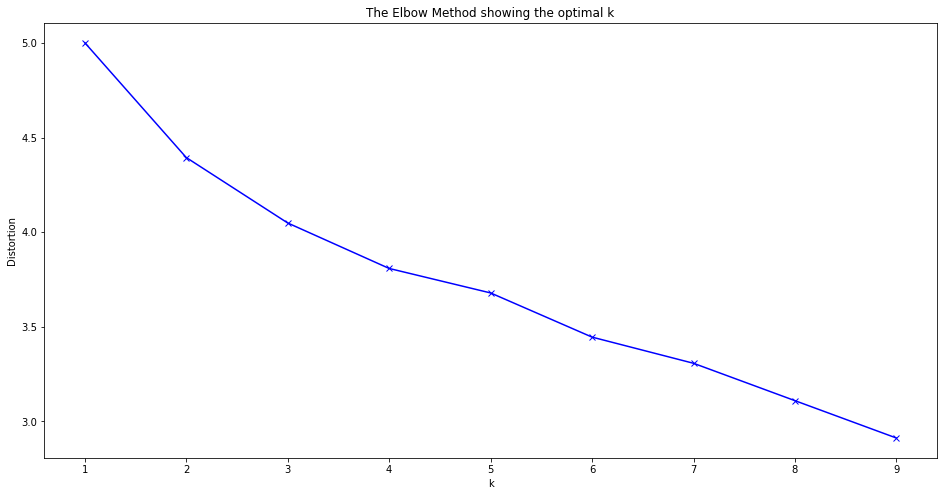

In [297]:
#let's plot the elbow method

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#this is not very conclusive, it is decided to use K=6

In [298]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(milano_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 3, 3, 4, 3, 3, 3, 0])

In [299]:
#insert the cluster labels in the dataframe

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [300]:
neighborhoods_venues_sorted

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,ADRIANO,Plaza,Supermarket,Clothing Store,Park,Electronics Store
1,1,AFFORI,Park,Hotel,Ice Cream Shop,Supermarket,Flea Market
2,1,BANDE NERE,Restaurant,Hotel,Plaza,Supermarket,Pub
3,3,BICOCCA,Steakhouse,Plaza,Sandwich Place,Sushi Restaurant,Diner
4,3,BOVISA,Piadineria,Vegetarian / Vegan Restaurant,Gym,Bakery,Bar
5,4,BOVISASCA,Soccer Field,Gym / Fitness Center,Restaurant,Bus Stop,Park
6,3,BRERA,Ice Cream Shop,Japanese Restaurant,Wine Bar,Hotel,Bakery
7,3,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,Cocktail Bar,Dessert Shop,Bakery,Plaza,Steakhouse
8,3,CITTA' STUDI,Tram Station,Pub,Plaza,Seafood Restaurant,Fast Food Restaurant
9,0,COMASINA,Gym / Fitness Center,Bakery,Bar,Convenience Store,Fast Food Restaurant


In [301]:
milano_merged = df_NIL.merge(neighborhoods_venues_sorted, how='inner', on='NIL')
milano_merged

,ID_NIL,NIL,NIL_Long,NIL_Lat,NIL_Area_mq,MUN,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,DUOMO,9.186948,45.463707,2.341704e+06,1,3,Plaza,Hotel,Ice Cream Shop,Monument / Landmark,Bakery
1,2,BRERA,9.188157,45.474252,1.637395e+06,1,3,Ice Cream Shop,Japanese Restaurant,Wine Bar,Hotel,Bakery
2,3,GIARDINI P.TA VENEZIA,9.200231,45.474564,2.496468e+05,1,3,Hotel,Gay Bar,Cocktail Bar,Bar,Sushi Restaurant
3,4,GUASTALLA,9.201891,45.463219,1.548021e+06,1,3,Furniture / Home Store,Clothing Store,Sandwich Place,Coffee Shop,Japanese Restaurant
4,5,PORTA VIGENTINA - PORTA LODOVICA,9.192446,45.450950,1.135239e+06,1,3,Wine Bar,Burger Joint,Cocktail Bar,Bistro,Plaza
5,6,PORTA TICINESE - CONCA DEL NAVIGLIO,9.181311,45.450475,1.255065e+06,1,3,Cocktail Bar,Ice Cream Shop,Hotel,Japanese Restaurant,Restaurant
6,7,MAGENTA - S. VITTORE,9.170394,45.464560,1.390147e+06,1,3,Plaza,Ice Cream Shop,Sandwich Place,Pastry Shop,Bar
7,8,PARCO SEMPIONE,9.176251,45.474131,4.704343e+05,1,3,Cocktail Bar,Wine Bar,Lounge,Nightclub,Gastropub
8,9,PORTA GARIBALDI - PORTA NUOVA,9.190579,45.483591,7.856683e+05,9,3,Restaurant,Japanese Restaurant,Cocktail Bar,Gourmet Shop,Plaza
9,10,STAZIONE CENTRALE - PONTE SEVESO,9.205795,45.487580,1.556078e+06,2,1,Hotel,Restaurant,Ice Cream Shop,Breakfast Spot,Chinese Restaurant


In [302]:
#drop null values

print(milano_merged.isnull().sum())
milano_merged.dropna(inplace=True)
print(milano_merged.isnull().sum())

ID_NIL                   0
NIL                      0
NIL_Long                 0
NIL_Lat                  0
NIL_Area_mq              0
MUN                      0
Cluster Labels           0
1st Most Common Venue    0
2nd Most Common Venue    0
3rd Most Common Venue    0
4th Most Common Venue    0
5th Most Common Venue    0
dtype: int64
ID_NIL                   0
NIL                      0
NIL_Long                 0
NIL_Lat                  0
NIL_Area_mq              0
MUN                      0
Cluster Labels           0
1st Most Common Venue    0
2nd Most Common Venue    0
3rd Most Common Venue    0
4th Most Common Venue    0
5th Most Common Venue    0
dtype: int64


In [303]:
#necessary to have int for changing color while plotting

milano_merged['Cluster Labels']=milano_merged['Cluster Labels'].astype(int)

In [304]:
milano_merged

,ID_NIL,NIL,NIL_Long,NIL_Lat,NIL_Area_mq,MUN,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,DUOMO,9.186948,45.463707,2.341704e+06,1,3,Plaza,Hotel,Ice Cream Shop,Monument / Landmark,Bakery
1,2,BRERA,9.188157,45.474252,1.637395e+06,1,3,Ice Cream Shop,Japanese Restaurant,Wine Bar,Hotel,Bakery
2,3,GIARDINI P.TA VENEZIA,9.200231,45.474564,2.496468e+05,1,3,Hotel,Gay Bar,Cocktail Bar,Bar,Sushi Restaurant
3,4,GUASTALLA,9.201891,45.463219,1.548021e+06,1,3,Furniture / Home Store,Clothing Store,Sandwich Place,Coffee Shop,Japanese Restaurant
4,5,PORTA VIGENTINA - PORTA LODOVICA,9.192446,45.450950,1.135239e+06,1,3,Wine Bar,Burger Joint,Cocktail Bar,Bistro,Plaza
5,6,PORTA TICINESE - CONCA DEL NAVIGLIO,9.181311,45.450475,1.255065e+06,1,3,Cocktail Bar,Ice Cream Shop,Hotel,Japanese Restaurant,Restaurant
6,7,MAGENTA - S. VITTORE,9.170394,45.464560,1.390147e+06,1,3,Plaza,Ice Cream Shop,Sandwich Place,Pastry Shop,Bar
7,8,PARCO SEMPIONE,9.176251,45.474131,4.704343e+05,1,3,Cocktail Bar,Wine Bar,Lounge,Nightclub,Gastropub
8,9,PORTA GARIBALDI - PORTA NUOVA,9.190579,45.483591,7.856683e+05,9,3,Restaurant,Japanese Restaurant,Cocktail Bar,Gourmet Shop,Plaza
9,10,STAZIONE CENTRALE - PONTE SEVESO,9.205795,45.487580,1.556078e+06,2,1,Hotel,Restaurant,Ice Cream Shop,Breakfast Spot,Chinese Restaurant


In [305]:
address = 'Milano, Italy'

geolocator = Nominatim(user_agent="MI_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Milano, Italy are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Milano, Italy are 45.4668, 9.1905.


In [326]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nil, cluster,id_nil in zip(milano_merged['NIL_Lat'], milano_merged['NIL_Long'], milano_merged['NIL'], milano_merged['Cluster Labels'],milano_merged['ID_NIL']):
    label = folium.Popup('ID:' + str(id_nil) + '  NIL:' + str(nil) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [307]:
#creating cluster0, cluster1 etc dataframe where store data about the single clusters

for i in range(0,kclusters):
    globals()['cluster'+str(i)] = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels']==i]

In [308]:
cluster0 #plaza areas

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,0,COMASINA,Gym / Fitness Center,Bakery,Bar,Convenience Store,Fast Food Restaurant
19,0,GRECO - SEGNANO,Plaza,Cocktail Bar,Chinese Restaurant,Theater,Steakhouse
22,0,LAMBRATE - ORTICA,Plaza,Bus Stop,Theater,Park,Supermarket
34,0,PORTA MAGENTA,Restaurant,Supermarket,Chinese Restaurant,Breakfast Spot,Convenience Store
43,0,SAN SIRO,Chinese Restaurant,Bus Stop,Bakery,Pharmacy,Plaza


In [309]:
cluster1 #hotel areas

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,1,AFFORI,Park,Hotel,Ice Cream Shop,Supermarket,Flea Market
2,1,BANDE NERE,Restaurant,Hotel,Plaza,Supermarket,Pub
10,1,CORSICA,Hotel,Bakery,Wine Shop,Seafood Restaurant,Wine Bar
11,1,DE ANGELI - MONTE ROSA,Hotel,Plaza,Bar,Breakfast Spot,Hostel
14,1,FARINI,Hotel,Supermarket,Cosmetics Shop,Bus Stop,Diner
23,1,LODI - CORVETTO,Nightclub,Hotel,Soccer Field,Vegetarian / Vegan Restaurant,Seafood Restaurant
25,1,MACIACHINI - MAGGIOLINA,Seafood Restaurant,Kebab Restaurant,Middle Eastern Restaurant,Hotel,Bakery
28,1,MORIVIONE,Tram Station,Bus Stop,Supermarket,Gym,Restaurant
38,1,PORTELLO,Japanese Restaurant,Hotel,Ice Cream Shop,Clothing Store,Plaza
44,1,SARPI,Hotel,Chinese Restaurant,Seafood Restaurant,Wine Shop,Bistro


In [310]:
cluster2 #areas with few venues, mainly residential (tram stations, supermarkets)

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
46,2,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...,Tram Station,Supermarket,Cocktail Bar,Gym,Pharmacy
54,2,VIGENTINO - Q.RE FATIMA,Tram Station,Seafood Restaurant,Supermarket,Wine Shop,Fast Food Restaurant


In [311]:
cluster3 #various venues

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,ADRIANO,Plaza,Supermarket,Clothing Store,Park,Electronics Store
3,3,BICOCCA,Steakhouse,Plaza,Sandwich Place,Sushi Restaurant,Diner
4,3,BOVISA,Piadineria,Vegetarian / Vegan Restaurant,Gym,Bakery,Bar
6,3,BRERA,Ice Cream Shop,Japanese Restaurant,Wine Bar,Hotel,Bakery
7,3,BUENOS AIRES - PORTA VENEZIA - PORTA MONFORTE,Cocktail Bar,Dessert Shop,Bakery,Plaza,Steakhouse
8,3,CITTA' STUDI,Tram Station,Pub,Plaza,Seafood Restaurant,Fast Food Restaurant
12,3,DERGANO,Restaurant,Plaza,Diner,Gym / Fitness Center,Ice Cream Shop
13,3,DUOMO,Plaza,Hotel,Ice Cream Shop,Monument / Landmark,Bakery
15,3,GHISOLFA,Tram Station,Trattoria/Osteria,Japanese Restaurant,Plaza,Wine Shop
16,3,GIAMBELLINO,Convenience Store,Hotel,Pub,Bar,Park


In [312]:
cluster4 #areas with soccer fields and gyms

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,4,BOVISASCA,Soccer Field,Gym / Fitness Center,Restaurant,Bus Stop,Park
27,4,MONCUCCO - SAN CRISTOFORO,Supermarket,Soccer Field,Ice Cream Shop,Gym,Bed & Breakfast


In [313]:
cluster5 #outlier, different from the others

,Cluster Labels,NIL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
40,5,Q.RE GALLARATESE - Q.RE SAN LEONARDO - LAMPUGNANO,Fast Food Restaurant,Asian Restaurant,Ice Cream Shop,Pharmacy,Clothing Store


#### Merging map with "Green Cloropleth Map"

In the notebook "5 Classification 'Green&Dogs' by NIL" it has been performed a Classification of the NILs using data about the city parks, such as extension, number of parks.
This analysis gave the results of the "greener"areas of Milano, shown in the choropleth map (the darker the greener)

In [317]:
df_choroplet_map=pd.read_csv('df_choroplet_map.csv') #file with NILs and "green labels"

In [319]:
import geojson
#geojson file with NIL coordinates
with open('ds964_nil_wm.geojson') as f:
    gj = geojson.load(f)

In [325]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.Choropleth(
    geo_data=gj,
    name='choropleth',
    data=df_choroplet_map,
    columns=['ID_NIL','choropleth'],
    key_on='feature.properties.ID_NIL',
    fill_color='YlGn',
    fill_opacity=1,
    line_opacity=1,
    legend_name='Cluster Labels',
).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)
# add markers to the map
markers_colors = []
for lat, lon, nil, cluster,id_nil in zip(milano_merged['NIL_Lat'], milano_merged['NIL_Long'], milano_merged['NIL'], milano_merged['Cluster Labels'],milano_merged['ID_NIL']):
    label = folium.Popup('ID:' + str(id_nil) + '  NIL:' + str(nil) + '  Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clusters)

    


map_clusters

#### Conclusions: 
The blue dots represents the NILs with the wider offer of services and venues. Combining this information with the greener NIL, it shows that the most "livable" areas in Milano are located in the center, in the western suburbs or in the north-east suburbs.